# Support Vector Regression for Price Prediction

Use Technical Analysis indicators as input features.

Split train/test
Fit SVR to technical indicators.
Report mean squared error.

Prediction for single stock. In this notebook, BBL is chosen arbitrary.
- Predict tomorrow's closing price.
- Use five technical indicators.
- Technical indicator choice and methodology came from Henrique2018.
- Model trained using data from 2014-2016. Model test on holdout data set of 2017, 2018-2020.
- Linear Kernel perform better than RBF. Confirms literature knowledge. RBF was getting 88 MSE on training.
- Linear Kernel performance degrades in holdout sets. MSE and MAE are increasing exponentially.


## Linear Kernel


| | In-sample (Training) | Out-of-sample (Holdout) | Out-of-sample (Holdout) |
| --- | --- | --- | --- |
| Year | 2014-2016 | 2017 | 2018-2020 |
| MSE | 6.23 | 8.039 | 13.778 |
| MAE | 1.979 | 2.25 | 2.40 |
| R2 | 0.860 | 0.975 | 0.985 |


## RBF Kernel

| | In-sample (Training) |
| --- | --- |
| Year | 2014-2016 |
| MSE | 23.828 |
| MAE | 3.23 |
| R2 | 0.903 |

 

TODO:
- Try Three-day, Five-day, Ten-day, Twenty-day ahead.
- Instead of price, predict returns instead b/c return is invariant and we would like to predict market invariant.


References
- HENRIQUE, Bruno Miranda; SOBREIRO, Vinicius Amorim; KIMURA, Herbert. Stock price prediction using support vector regression on daily and up to the minute prices. The Journal of finance and data science, 2018, 4.3: 183-201.
- Support Vector Regression in Python Using Scikit-Learn https://heartbeat.fritz.ai/support-vector-regression-in-python-using-scikit-learn-89cc18e933b7
- In-Depth: Support Vector Machines https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html#Fitting-a-support-vector-machine
- Support vector regression for multivariate time series prediction
https://stats.stackexchange.com/questions/14482/support-vector-regression-for-multivariate-time-series-prediction
- SVM From Scratch — Python https://towardsdatascience.com/svm-implementation-from-scratch-python-2db2fc52e5c2
- Support Vector Regression in 6 Steps with Python https://medium.com/pursuitnotes/support-vector-regression-in-6-steps-with-python-c4569acd062d
- Awad M., Khanna R. (2015) Support Vector Regression. In: Efficient Learning Machines. Apress, Berkeley, CA https://link.springer.com/chapter/10.1007/978-1-4302-5990-9_4

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import os, os.path
import talib

In [2]:
DATA_HOME = os.path.join("..","historical")

symbols = ['ADVANC', 'AOT', 'BANPU', 'BBL', 'BDMS', 'BEM', 'BGRIM', 'BH', 'BJC', 'BTS']
data = {}
for s in symbols:
    data[s] = pd.read_csv(os.path.join(DATA_HOME,"%s.csv" % s), index_col=0)

df = data["BBL"]
df.index = pd.to_datetime(df.index)
daily = df['2014-01-01':'2016-12-31']

In [3]:
from talib.abstract import *

inputs = {
    'open': daily["Open"],
    'high': daily["High"],
    'low': daily["Low"],
    'close': daily["Close"],
    'volume': daily["Volume"]
}

daily.loc[:,"SMA"] = SMA(inputs, timeperiod=25).tolist()
daily.loc[:,"WMA"] = WMA(inputs).tolist()
daily.loc[:,"ADOSC"] = ADOSC(inputs).tolist()
daily.loc[:,"ATR"] = ATR(inputs).tolist()
daily.loc[:,"RSI"] = RSI(inputs).tolist()

daily

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI
Date,,,,,,,,,,,
2014-01-02,178.5,166.0,178.5,166.0,9335900.0,128.947006,NaN,NaN,NaN,NaN,NaN
2014-01-03,170.0,166.0,166.0,168.5,9506900.0,130.889008,NaN,NaN,NaN,NaN,NaN
2014-01-06,175.5,165.0,168.0,173.5,9790700.0,134.772934,NaN,NaN,NaN,NaN,NaN
2014-01-07,180.0,173.5,174.0,178.0,5719200.0,138.268524,NaN,NaN,NaN,NaN,NaN
2014-01-08,182.0,177.5,179.0,177.5,9392300.0,137.880112,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-26,158.0,157.0,158.0,157.5,969400.0,136.304535,156.44,156.644086,7.059610e+05,1.971332,51.586110
2016-12-27,159.0,157.0,157.5,158.0,1224700.0,136.737228,156.50,156.741935,7.036331e+05,1.973379,53.388715
2016-12-28,158.5,157.0,158.0,158.0,907600.0,136.737228,156.58,156.844086,7.349748e+05,1.939567,53.388715


# Prepare feature

We want X,y before splitting.

In [4]:
data = daily

# Target: Tomorrow's closing price
data["Tomorrow"] = data["Close"].shift(-1)
data = data.dropna()

# Features: SMA, ATR, RSI AD

features = data[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values
target = data[["Tomorrow"]].values

# data[[SMA, WMA, RSI, ADOSC, ATR]]
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Tomorrow
Date,,,,,,,,,,,,
2014-02-12,179.0,175.5,177.0,179.0,5224500.0,139.045288,175.56,174.889247,5.162544e+06,3.708533,62.566777,177.0
2014-02-13,179.5,176.0,179.5,177.0,3427500.0,137.491714,175.52,175.012903,4.836866e+06,3.693638,58.521278,176.5
2014-02-17,178.0,176.0,177.0,176.5,7117300.0,137.103302,175.50,175.080645,3.131622e+06,3.572663,57.519961,176.0
2014-02-18,176.5,175.0,176.0,176.0,8808500.0,136.714920,175.28,175.098925,3.083564e+06,3.424616,56.479247,172.5
2014-02-19,176.0,172.0,175.0,172.5,9340200.0,133.996170,174.94,174.886022,5.546681e+05,3.465715,49.700406,171.5
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,158.0,155.5,156.5,158.0,2080600.0,136.737228,156.38,156.588172,5.547710e+05,2.046049,53.507610,157.5
2016-12-26,158.0,157.0,158.0,157.5,969400.0,136.304535,156.44,156.644086,7.059610e+05,1.971332,51.586110,158.0
2016-12-27,159.0,157.0,157.5,158.0,1224700.0,136.737228,156.50,156.741935,7.036331e+05,1.973379,53.388715,158.0


In [5]:
# Prepare data for training. Split train/test 60/40.
# TODO: get rid of random_state to check when everything is stable?

X = features
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## SVR - RBF Kernel

In [6]:
# Use StandardScaler 
# Note about pipeline
# see https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svr = SVR(kernel='rbf') # RBF kernel. Note the result here is poorer than linear kernel.
model = make_pipeline(StandardScaler(), svr)

In [7]:
model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [8]:
y_pred = model.predict(X_test)
# y_pred # Check output

In [9]:
mse = mean_squared_error(y_test, y_pred)
mse

23.828357985387463

In [10]:
rmse = np.sqrt(mse)
rmse

4.881429911960988

In [11]:
mae = mean_absolute_error(y_test, y_pred)
mae

3.2337772528998587

In [12]:
r2 = r2_score(y_test, y_pred)
r2

0.9032471658618555

In [13]:
# Report metric

{
    'mse': mse,
    'mae': mae,
    'r2': r2
}

{'mse': 23.828357985387463,
 'mae': 3.2337772528998587,
 'r2': 0.9032471658618555}

# SVR - Linear Kernel

In [14]:
svr = SVR(kernel='linear')
model = make_pipeline(StandardScaler(), svr)
model.fit(X_train, y_train)



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='linear', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

In [15]:
y_pred = model.predict(X_test)

In [16]:
mse = mean_squared_error(y_test, y_pred)
mse

6.232599625023443

In [17]:
mae = mean_absolute_error(y_test, y_pred)
mae

1.9787348026631508

In [18]:
r2 = r2_score(y_test, y_pred)
r2

0.9746931081806328

In [19]:
# Report metric

{
    'mse': mse,
    'mae': mae,
    'r2': r2
}

{'mse': 6.232599625023443, 'mae': 1.9787348026631508, 'r2': 0.9746931081806328}

# Test on holdout set 1

In [20]:
holdout = df["2017-01-01":"2017-12-31"]
holdout

inputs = {
    'open': holdout["Open"],
    'high': holdout["High"],
    'low': holdout["Low"],
    'close': holdout["Close"],
    'volume': holdout["Volume"]
}

holdout.loc[:,"SMA"] = SMA(inputs, timeperiod=25).tolist()
holdout.loc[:,"WMA"] = WMA(inputs).tolist()
holdout.loc[:,"ADOSC"] = ADOSC(inputs).tolist()
holdout.loc[:,"ATR"] = ATR(inputs).tolist()
holdout.loc[:,"RSI"] = RSI(inputs).tolist()

holdout

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI
Date,,,,,,,,,,,
2017-01-04,163.5,159.5,159.5,163.0,4611800.0,141.064362,NaN,NaN,NaN,NaN,NaN
2017-01-05,164.5,163.0,163.0,164.0,4460400.0,141.929779,NaN,NaN,NaN,NaN,NaN
2017-01-06,164.5,162.5,164.0,164.5,2373300.0,142.362488,NaN,NaN,NaN,NaN,NaN
2017-01-09,164.5,163.0,163.0,164.0,2430100.0,141.929779,NaN,NaN,NaN,NaN,NaN
2017-01-10,169.5,164.5,164.5,168.0,11248900.0,145.391495,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-25,206.0,204.0,205.0,206.0,2155000.0,184.746002,202.06,202.944086,8.627705e+05,2.759792,63.655090
2017-12-26,206.0,204.0,205.0,204.0,2163100.0,182.952362,202.36,203.168817,2.896975e+05,2.705522,56.714136
2017-12-27,205.0,203.0,204.0,203.0,2218100.0,182.055527,202.66,203.302151,-6.768367e+05,2.655127,53.568899


In [21]:
# Target: Tomorrow's closing price
data = daily


holdout["Actual"] = holdout["Close"].shift(-1) # tomorrow's price if known today.
holdout.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Actual
Date,,,,,,,,,,,,
2017-01-04,163.5,159.5,159.5,163.0,4611800.0,141.064362,NaN,NaN,NaN,NaN,NaN,164.0
2017-01-05,164.5,163.0,163.0,164.0,4460400.0,141.929779,NaN,NaN,NaN,NaN,NaN,164.5
2017-01-06,164.5,162.5,164.0,164.5,2373300.0,142.362488,NaN,NaN,NaN,NaN,NaN,164.0
2017-01-09,164.5,163.0,163.0,164.0,2430100.0,141.929779,NaN,NaN,NaN,NaN,NaN,168.0
2017-01-10,169.5,164.5,164.5,168.0,11248900.0,145.391495,NaN,NaN,NaN,NaN,NaN,167.0


In [22]:
# Tomorrow predict
holdout = holdout.dropna()

holdout[0:1]

,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Actual
Date,,,,,,,,,,,,
2017-02-16,180.0,177.0,178.0,180.0,1664200.0,155.776611,174.12,175.806452,6.116445e+06,2.649671,66.859485,180.0


In [23]:
# Test predicting on one sample.

features = holdout[0:1][["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values
features

y_pred = model.predict(features)
y_pred

array([183.10628894])

In [24]:
# Prediction for the holdout set.

holdout.loc[:,"Predict"] = model.predict(holdout[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values)
holdout

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Actual,Predict
Date,,,,,,,,,,,,,
2017-02-16,180.0,177.0,178.0,180.0,1664200.0,155.776611,174.12,175.806452,6.116445e+06,2.649671,66.859485,180.0,183.106289
2017-02-17,181.0,180.0,180.5,180.0,1498800.0,155.776611,174.64,176.287097,5.183650e+06,2.531837,66.859485,180.0,183.654080
2017-02-20,180.5,179.0,180.0,180.0,855800.0,155.776611,175.20,176.731183,4.421578e+06,2.458135,66.859485,177.0,184.160007
2017-02-21,180.5,177.0,180.0,177.0,1898500.0,153.180298,175.54,176.947312,3.103791e+06,2.532554,56.274319,177.0,179.894086
2017-02-22,178.0,176.0,178.0,177.0,1768800.0,153.180298,175.94,177.136559,2.282534e+06,2.494514,56.274319,176.5,180.141131
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,207.0,204.0,206.0,205.0,1485500.0,183.849182,201.66,202.559140,3.894777e+05,2.818238,61.465500,206.0,206.819206
2017-12-25,206.0,204.0,205.0,206.0,2155000.0,184.746002,202.06,202.944086,8.627705e+05,2.759792,63.655090,204.0,208.210044
2017-12-26,206.0,204.0,205.0,204.0,2163100.0,182.952362,202.36,203.168817,2.896975e+05,2.705522,56.714136,203.0,205.640847


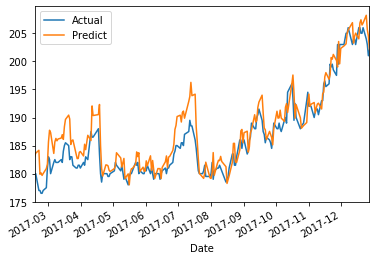

In [25]:
holdout[["Actual", "Predict"]].plot()

In [26]:
mse = mean_squared_error(holdout[["Actual"]].values, holdout[["Predict"]].values)
mse

8.039170674141907

In [27]:
mae = mean_absolute_error(holdout[["Actual"]].values, holdout[["Predict"]].values)
mae

2.250588329430674

In [28]:
r2 = r2_score(holdout[["Actual"]].values, holdout[["Predict"]].values)
r2

0.8597474758557941

In [29]:
# Report metric

{
    'mse': mse,
    'mae': mae,
    'r2': r2
}

{'mse': 8.039170674141907, 'mae': 2.250588329430674, 'r2': 0.8597474758557941}

# Test on holdout set 2: 2018-2020

In [30]:
holdout2 = df["2018-01-01":"2020-04-30"]
holdout2


inputs = {
    'open': holdout2["Open"],
    'high': holdout2["High"],
    'low': holdout2["Low"],
    'close': holdout2["Close"],
    'volume': holdout2["Volume"]
}

holdout2.loc[:,"SMA"] = SMA(inputs, timeperiod=25).tolist()
holdout2.loc[:,"WMA"] = WMA(inputs).tolist()
holdout2.loc[:,"ADOSC"] = ADOSC(inputs).tolist()
holdout2.loc[:,"ATR"] = ATR(inputs).tolist()
holdout2.loc[:,"RSI"] = RSI(inputs).tolist()

# Tomorrow actual
holdout2.loc[:,"Actual"] = holdout2["Close"].shift(-1)
holdout2.head()

# Start prediction
holdout2 = holdout2.dropna()

holdout2.loc[:,"Predict"] = model.predict(holdout2[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values)
holdout2

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Actual,Predict
Date,,,,,,,,,,,,,
2018-02-13,207.0,205.0,206.0,205.0,3061900.0,183.849182,209.24,208.503226,1.798839e+06,3.781375,45.357466,206.0,205.732233
2018-02-14,207.0,205.0,205.0,206.0,2067500.0,184.746002,209.24,208.326882,1.099762e+06,3.654134,47.983524,206.0,206.796105
2018-02-15,207.0,205.0,205.0,206.0,1948500.0,184.746002,209.16,208.148387,7.137968e+05,3.535982,47.983524,206.0,206.769145
2018-02-16,209.0,206.0,207.0,206.0,2205400.0,184.746002,209.04,207.967742,-2.107066e+05,3.497697,47.983524,208.0,206.581350
2018-02-19,208.0,207.0,207.0,208.0,791400.0,186.539658,208.88,207.916129,-3.179483e+05,3.390719,53.558739,205.0,208.882058
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-23,106.0,103.0,103.5,104.5,11668100.0,104.500000,102.47,105.139247,-2.363235e+06,5.514295,45.481785,103.0,100.330996
2020-04-24,105.0,102.5,104.5,103.0,9348500.0,103.000000,103.03,105.222581,-4.326668e+06,5.298988,44.093302,101.0,100.129050
2020-04-27,103.5,100.0,103.0,101.0,6699600.0,101.000000,103.17,105.184409,-5.650139e+06,5.170489,42.241616,100.0,99.446536


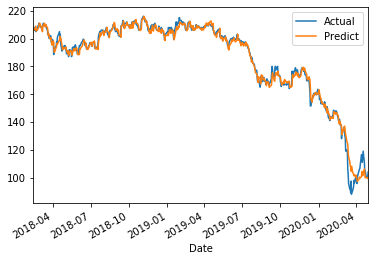

In [31]:
holdout2[["Actual", "Predict"]].plot()

In [32]:
mse = mean_squared_error(holdout2[["Actual"]].values, holdout2[["Predict"]].values)
mse

13.77868254106028

In [33]:
mae = mean_absolute_error(holdout2[["Actual"]].values, holdout2[["Predict"]].values)
mae

2.4015053859350624

In [34]:
r2 = r2_score(holdout2[["Actual"]].values, holdout2[["Predict"]].values)
r2

0.9848599179683595

In [35]:
# Report metric

{
    'mse': mse,
    'mae': mae,
    'r2': r2
}

{'mse': 13.77868254106028, 'mae': 2.4015053859350624, 'r2': 0.9848599179683595}